In [1]:
#! /usr/bin/python3
import re
import os
import dendropy
from dendropy.calculate import treecompare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# input the path to the gon_phyling folder you wish to analyze
replicate_dir = ""

# path to "TRUE" tree file
true_tree_file = ""

In [9]:
# generate robinson-foulds distances for phycorder-gon_phyling tree comparisons
maj_rule_weighted_rfs_dict = {}
maj_rule_unweighted_rfs_dict = {}

weighted_rfs_dict = {}
unweighted_rfs_dict = {}

replicate_count = 0
taxa_count = []
maj_rule_taxa_count = []

os.chdir(replicate_dir)

list_of_rep_dirs = []
dir_list = os.listdir(".")
for file in dir_list:
    if "combined_output-" in file:
        list_of_rep_dirs.append(file)
    else:
        continue

# looping through directories of runs
for dir_name in list_of_rep_dirs:
    os.chdir(dir_name)
    rep_files = os.listdir(".")
    phycord_best_trees = []
    gon_phy_best_trees = []
    phycord_maj_rule_trees = []
    gon_phy_maj_rule_trees = []
    
    replicate_count+=1
    
    maj_rule_weighted_rfs_dict[replicate_count] = {}
    maj_rule_unweighted_rfs_dict[replicate_count] = {}
    
    unweighted_rfs_dict[replicate_count] = {}
    weighted_rfs_dict[replicate_count] = {}
    
    weighted_rfs = []
    unweighted_rfs = []
    
    maj_rule_weighted_rfs = []
    maj_rule_unweighted_rfs = []
    
    for file in rep_files:
        if "RAxML_bestTree.phycorder-" in file:
            phycord_best_trees.append(file)
        elif "RAxML_bestTree.gon_phy-" in file:
            gon_phy_best_trees.append(file)
        elif "RAxML_bipartitions.phycorder_majority_rule-" in file:
            phycord_maj_rule_trees.append(file)
        elif "RAxML_bipartitions.gon_phy_majority_rule-" in file:
            gon_phy_maj_rule_trees.append(file)
        
        else:
            continue
    
    phycord_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    gon_phy_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    phycord_maj_rule_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    gon_phy_maj_rule_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    #print("\n")
    #print("**")
    #print("NEW REPLICATE NUMBERS")
    #print("**")
    #print("\n")
    
    # looping through output files in directory
    for phycord_count, phycord_tree in enumerate(phycord_best_trees):
        tree_file_open = open(phycord_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in taxa_count:
            taxa_count.append(step_count_taxa)
        for gon_phy_count, gon_phy_tree in enumerate(gon_phy_best_trees):
            if phycord_count == gon_phy_count:
                
                
                # establish common taxon namespace
                tns = dendropy.TaxonNamespace()
                
                # ensure all trees loaded use common namespace
                tree1 = dendropy.Tree.get(
                path = gon_phy_tree,
                schema='newick',
                taxon_namespace=tns)

                tree2 = dendropy.Tree.get(
                path = phycord_tree,
                schema = 'newick',
                taxon_namespace = tns)
    
                best_tree_unweighted = treecompare.symmetric_difference(tree1, tree2)
                #print(best_tree_unweighted)
                unweighted_rfs.append(best_tree_unweighted)
                
                best_tree_weighted = treecompare.weighted_robinson_foulds_distance(tree1, tree2)
                #print(best_tree_weighted)
                weighted_rfs.append(best_tree_weighted)
                print(weighted_rfs)
                
    for phycord_count, phycord_maj_rule_tree in enumerate(phycord_maj_rule_trees):
        tree_file_open = open(phycord_maj_rule_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in maj_rule_taxa_count:
            maj_rule_taxa_count.append(step_count_taxa)
        for gon_phy_count, gon_phy_maj_rule_tree in enumerate(gon_phy_maj_rule_trees):
            if phycord_count == gon_phy_count:
                
                
                # establish common taxon namespace
                tns = dendropy.TaxonNamespace()
                
                # ensure all trees loaded use common namespace
                tree1 = dendropy.Tree.get(
                path = gon_phy_maj_rule_tree,
                schema='newick',
                taxon_namespace=tns)

                tree2 = dendropy.Tree.get(
                path = phycord_maj_rule_tree,
                schema = 'newick',
                taxon_namespace = tns)
    
                maj_rule_unweighted = treecompare.symmetric_difference(tree1, tree2)
                #print(best_tree_unweighted)
                maj_rule_unweighted_rfs.append(maj_rule_unweighted)
                
                maj_rule_weighted = treecompare.weighted_robinson_foulds_distance(tree1, tree2)
                #print(best_tree_weighted)
                maj_rule_weighted_rfs.append(maj_rule_weighted)
    #print(unweighted_rfs)
    #print(weighted_rfs)
    #print(taxa_count)
    
    weight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(weighted_rfs):
            if num1 == num2:
                weight_temp_dict[count] = rf
    weighted_rfs_dict[replicate_count] = weight_temp_dict
    
    unweight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(unweighted_rfs):
            if num1 == num2:
                unweight_temp_dict[count] = rf
    unweighted_rfs_dict[replicate_count] = unweight_temp_dict
    
    mr_weight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(maj_rule_weighted_rfs):
            if num1 == num2:
                mr_weight_temp_dict[count] = rf
    maj_rule_weighted_rfs_dict[replicate_count] = mr_weight_temp_dict
    
    mr_unweight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(maj_rule_unweighted_rfs):
            if num1 == num2:
                mr_unweight_temp_dict[count] = rf
    maj_rule_unweighted_rfs_dict[replicate_count] = mr_unweight_temp_dict
    
                
    os.chdir(replicate_dir)
#print(unweighted_rfs_dict)
#print(weighted_rfs_dict)

unweighted_df = pd.DataFrame.from_dict(unweighted_rfs_dict ,orient='columns')
weighted_df = pd.DataFrame.from_dict(weighted_rfs_dict,orient='columns')
mr_unweighted_df = pd.DataFrame.from_dict(maj_rule_unweighted_rfs_dict ,orient='columns')
mr_weighted_df = pd.DataFrame.from_dict(maj_rule_weighted_rfs_dict,orient='columns')

mr_unweighted_df.head()

[0.0025564026251156348]
[0.0025564026251156348, 0.0061131174400408375]
[0.0025564026251156348, 0.0061131174400408375, 0.00631018603334739]
[0.0025564026251156348, 0.0061131174400408375, 0.00631018603334739, 0.007067067091778714]
[0.0025564026251156348, 0.0061131174400408375, 0.00631018603334739, 0.007067067091778714, 0.007443783606403854]
[0.0028785214249493767]
[0.0028785214249493767, 0.006210676435900126]
[0.0028785214249493767, 0.006210676435900126, 0.0062624764047161585]
[0.0028785214249493767, 0.006210676435900126, 0.0062624764047161585, 0.007119844042695275]
[0.0028785214249493767, 0.006210676435900126, 0.0062624764047161585, 0.007119844042695275, 0.007567065679445894]


,1,2


In [4]:
# process comparison df's for plotting
unweighted_df['mean rf'] = unweighted_df.mean(axis=1)
unweighted_mean = unweighted_df['mean rf']
unweighted_df['std'] = unweighted_df.std(axis=1)
unweighted_df.head()

mr_unweighted_df['mean rf'] = mr_unweighted_df.mean(axis=1)
mr_unweighted_mean = mr_unweighted_df['mean rf']
mr_unweighted_df['std'] = mr_unweighted_df.std(axis=1)
mr_unweighted_df.head()

weighted_df['mean rf'] = weighted_df.mean(axis=1)
weighted_mean = weighted_df['mean rf']
weighted_df['std'] = weighted_df.std(axis=1)
weighted_df.head()

mr_weighted_df['mean rf'] = mr_weighted_df.mean(axis=1)
mr_weighted_mean = mr_weighted_df['mean rf']
mr_weighted_df['std'] = mr_weighted_df.std(axis=1)
mr_weighted_df.head()

unweighted_df['isolate number'] = unweighted_df.index
unweighted_df.head()

mr_unweighted_df['isolate number'] = mr_unweighted_df.index
mr_unweighted_df.head()

weighted_df['isolate number'] = weighted_df.index
weighted_df.head()

mr_weighted_df['isolate number'] = mr_weighted_df.index
mr_weighted_df.head()

,1,2,mean rf,std,isolate number


In [3]:
# Calculating absolute Error section between "True" tree and esimate trees

tree = open(true_tree_file,'r')
read_tree = tree.read()

# establishes how to count each taxon in a tree in order to calculate maxRF
name_id = "taxon"

# regex that searches for names based on how we expect taxa to be named in the tree
name_regex = name_id + "_\d+"

name_grabber = re.compile(name_regex)

# find all taxa names in tree
true_tree_taxa_names = re.findall(name_grabber, read_tree)

# count the number of taxa in the tree
taxa_counter = 0
for item in true_tree_taxa_names:
    taxa_counter+=1

# begin getting rf comparisons for all trees vs the TRUE tree
phycorder_maj_rule_weighted_rfs_dict = {}
phycorder_maj_rule_unweighted_rfs_dict = {}

gon_phyling_maj_rule_weighted_rfs_dict = {}
gon_phyling_maj_rule_unweighted_rfs_dict = {}

phycorder_weighted_rfs_dict = {}
phycorder_unweighted_rfs_dict = {}

gon_phyling_weighted_rfs_dict = {}
gon_phyling_unweighted_rfs_dict = {}

replicate_count = 0
taxa_count = []
maj_rule_taxa_count = []

os.chdir(replicate_dir)

list_of_rep_dirs = []
dir_list = os.listdir(".")
for file in dir_list:
    if "combined_output-" in file:
        list_of_rep_dirs.append(file)
    else:
        continue


# looping through directories of runs
for dir_name in list_of_rep_dirs:
    os.chdir(dir_name)
    rep_files = os.listdir(".")
    phycord_best_trees = []
    gon_phy_best_trees = []
    phycord_maj_rule_trees = []
    gon_phy_maj_rule_trees = []
    
    replicate_count+=1
    
    phycorder_maj_rule_weighted_rfs_dict[replicate_count] = {}
    phycorder_maj_rule_unweighted_rfs_dict[replicate_count] = {}
    
    gon_phyling_maj_rule_weighted_rfs_dict[replicate_count] = {}
    gon_phyling_maj_rule_unweighted_rfs_dict[replicate_count] = {}
    
    phycorder_unweighted_rfs_dict[replicate_count] = {}
    phycorder_weighted_rfs_dict[replicate_count] = {}
    
    gon_phyling_unweighted_rfs_dict[replicate_count] = {}
    gon_phyling_weighted_rfs_dict[replicate_count] = {}
    
    phycorder_weighted_rfs = []
    phycorder_unweighted_rfs = []
    
    gon_phyling_weighted_rfs = []
    gon_phyling_unweighted_rfs = []
    
    phycorder_maj_rule_weighted_rfs = []
    phycorder_maj_rule_unweighted_rfs = []
    
    gon_phyling_maj_rule_weighted_rfs = []
    gon_phyling_maj_rule_unweighted_rfs = []
    
    for file in rep_files:
        if "RAxML_bestTree.phycorder-" in file:
            phycord_best_trees.append(file)
        elif "RAxML_bestTree.gon_phy-" in file:
            gon_phy_best_trees.append(file)
        elif "RAxML_bipartitions.phycorder_majority_rule-" in file:
            phycord_maj_rule_trees.append(file)
        elif "RAxML_bipartitions.gon_phy_majority_rule-" in file:
            gon_phy_maj_rule_trees.append(file)
        
        else:
            continue
            
    
    phycord_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    gon_phy_best_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    phycord_maj_rule_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    gon_phy_maj_rule_trees.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    #print("\n")
    #print("**")
    #print("NEW REPLICATE NUMBERS")
    #print("**")
    #print("\n")

    
    # looping through phycorder best tree files
    for phycord_count, phycord_tree in enumerate(phycord_best_trees):
        
        tree_file_open = open(phycord_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in taxa_count:
            taxa_count.append(step_count_taxa)
        
        phycord_taxa_names = re.findall(name_grabber, read_tree)
        
        shared_names_list = []
        for name in true_tree_taxa_names:
            if name in phycord_taxa_names:
                shared_names_list.append(name)
        
        
        names_not_shared_list = []
        for name in true_tree_taxa_names:
            if name not in shared_names_list:
                names_not_shared_list.append(name)


        # establish common taxon namespace
        tns = dendropy.TaxonNamespace()
                
        # ensure all trees loaded use common namespace
        true_tree = dendropy.Tree.get(
            path = true_tree_file,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        # remove tips from true tree that aren't present in current estimate tree
        true_tree.prune_taxa_with_labels(names_not_shared_list)
        
        tree2 = dendropy.Tree.get(
            path = phycord_tree,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        assert len(true_tree.leaf_nodes()) == len(tree2.leaf_nodes())
        

        
        
        best_tree_unweighted = treecompare.symmetric_difference(true_tree, tree2)
        #print(best_tree_unweighted)
        phycorder_unweighted_rfs.append(best_tree_unweighted)
        #print("unweighted_RF:{rf}".format(rf = best_tree_unweighted))
        
        best_tree_weighted = treecompare.weighted_robinson_foulds_distance(true_tree, tree2)
        #print(best_tree_weighted)
        phycorder_weighted_rfs.append(best_tree_weighted)
        #print(best_tree_weighted)
        
        
    # loop through gon_pyling best trees in directory
    for gon_phy_count, gon_phy_tree in enumerate(gon_phy_best_trees):
        
        tree_file_open = open(gon_phy_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in taxa_count:
            taxa_count.append(step_count_taxa)
        
        gon_phy_taxa_names = re.findall(name_grabber, read_tree)
        
        shared_names_list = []
        for name in true_tree_taxa_names:
            if name in gon_phy_taxa_names:
                shared_names_list.append(name)
        
        names_not_shared_list = []
        for name in true_tree_taxa_names:
            if name not in shared_names_list:
                names_not_shared_list.append(name)


        # establish common taxon namespace
        tns = dendropy.TaxonNamespace()
                
        # ensure all trees loaded use common namespace
        true_tree = dendropy.Tree.get(
            path = true_tree_file,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        #true_tree.write(path="", schema="newick")
        
        # remove tips from true tree that aren't present in current estimate tree
        true_tree.prune_taxa_with_labels(names_not_shared_list)
        #true_tree.write(path="", schema="newick")
        
        
        tree2 = dendropy.Tree.get(
            path = gon_phy_tree,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        assert len(true_tree.leaf_nodes()) == len(tree2.leaf_nodes())
        
        #tree2.write(path="", schema="newick")
        
        
        gon_phy_best_tree_unweighted = treecompare.symmetric_difference(true_tree, tree2)
        #print(best_tree_unweighted)
        gon_phyling_unweighted_rfs.append(gon_phy_best_tree_unweighted)
        #print("unweighted_RF:{rf}".format(rf = gon_phy_best_tree_unweighted))
        
        gon_phy_best_tree_weighted = treecompare.weighted_robinson_foulds_distance(true_tree, tree2)
        #print(best_tree_weighted)
        gon_phyling_weighted_rfs.append(gon_phy_best_tree_weighted)
        #print(gon_phy_best_tree_weighted)

    
    
    # loop through phycorder majority rule trees in directory
    for phycord_count, phycord_tree in enumerate(phycord_maj_rule_trees):
        
        tree_file_open = open(phycord_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in maj_rule_taxa_count:
            maj_rule_taxa_count.append(step_count_taxa)
        
        phycord_taxa_names = re.findall(name_grabber, read_tree)
        
        shared_names_list = []
        for name in true_tree_taxa_names:
            if name in phycord_taxa_names:
                shared_names_list.append(name)
        
        names_not_shared_list = []
        for name in true_tree_taxa_names:
            if name not in shared_names_list:
                names_not_shared_list.append(name)


        # establish common taxon namespace
        tns = dendropy.TaxonNamespace()
                
        # ensure all trees loaded use common namespace
        true_tree = dendropy.Tree.get(
            path = true_tree_file,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        #true_tree.write(path="", schema="newick")
        
        # remove tips from true tree that aren't present in current estimate tree
        true_tree.prune_taxa_with_labels(names_not_shared_list)
        #true_tree.write(path="", schema="newick")
        
        
        tree2 = dendropy.Tree.get(
            path = phycord_tree,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        assert len(true_tree.leaf_nodes()) == len(tree2.leaf_nodes())
        
        #tree2.write(path="", schema="newick")
        
        
        majority_rule_unweighted = treecompare.symmetric_difference(true_tree, tree2)
        #print(best_tree_unweighted)
        phycorder_maj_rule_unweighted_rfs.append(majority_rule_unweighted)
        #print("unweighted_RF:{rf}".format(rf = majority_rule_unweighted))
        
        majority_rule_weighted = treecompare.weighted_robinson_foulds_distance(true_tree, tree2)
        #print(best_tree_weighted)
        phycorder_maj_rule_weighted_rfs.append(majority_rule_weighted)
        #print(majority_rule_weighted)
        
    
    
    # loop through gon_pyling majority rule trees in directory
    for gon_phy_count, gon_phy_tree in enumerate(gon_phy_maj_rule_trees):
        
        tree_file_open = open(gon_phy_tree, 'r')
        read_tree = tree_file_open.read()
        step_count_taxa = read_tree.count("taxon")
        if step_count_taxa not in maj_rule_taxa_count:
            maj_rule_taxa_count.append(step_count_taxa)
        
        gon_phy_taxa_names = re.findall(name_grabber, read_tree)
        
        shared_names_list = []
        for name in true_tree_taxa_names:
            if name in gon_phy_taxa_names:
                shared_names_list.append(name)
        
        names_not_shared_list = []
        for name in true_tree_taxa_names:
            if name not in shared_names_list:
                names_not_shared_list.append(name)


        # establish common taxon namespace
        tns = dendropy.TaxonNamespace()
                
        # ensure all trees loaded use common namespace
        true_tree = dendropy.Tree.get(
            path = true_tree_file,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        # remove tips from true tree that aren't present in current estimate tree
        true_tree.prune_taxa_with_labels(names_not_shared_list)
        
        
        
        tree2 = dendropy.Tree.get(
            path = gon_phy_tree,
            schema = 'newick',
            preserve_underscores = True,
            taxon_namespace = tns)
        
        
        
        assert len(true_tree.leaf_nodes()) == len(tree2.leaf_nodes())
        
        #tree2.write(path="", schema="newick")
        
        
        gon_phy_maj_rule_unweighted = treecompare.symmetric_difference(true_tree, tree2)
        #print(best_tree_unweighted)
        gon_phyling_maj_rule_unweighted_rfs.append(gon_phy_maj_rule_unweighted)
        #print("unweighted_RF:{rf}".format(rf = gon_phy_maj_rule_unweighted))
        
        gon_phy_maj_rule_weighted = treecompare.weighted_robinson_foulds_distance(true_tree, tree2)
        #print(best_tree_weighted)
        gon_phyling_maj_rule_weighted_rfs.append(gon_phy_maj_rule_weighted)
        #print(gon_phy_maj_rule_weighted)

    

    # process RFs and add them to dictionaries before turning them into dataframes
    phycorder_unweight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(phycorder_unweighted_rfs):
            if num1 == num2:
                phycorder_unweight_temp_dict[count] = rf
    phycorder_unweighted_rfs_dict[replicate_count] = phycorder_unweight_temp_dict
    
    phycorder_weight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(phycorder_weighted_rfs):
            if num1 == num2:
                phycorder_weight_temp_dict[count] = rf
    phycorder_weighted_rfs_dict[replicate_count] = phycorder_weight_temp_dict
    
    
    
    
    gon_phyling_unweight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(gon_phyling_unweighted_rfs):
            if num1 == num2:
                gon_phyling_unweight_temp_dict[count] = rf
    gon_phyling_unweighted_rfs_dict[replicate_count] = gon_phyling_unweight_temp_dict
    
    gon_phyling_weight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(gon_phyling_weighted_rfs):
            if num1 == num2:
                gon_phyling_weight_temp_dict[count] = rf
    gon_phyling_weighted_rfs_dict[replicate_count] = gon_phyling_weight_temp_dict
      
    
    
    
    phycord_maj_rule_weight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(phycorder_maj_rule_weighted_rfs):
            if num1 == num2:
                phycord_maj_rule_weight_temp_dict[count] = rf
    phycorder_maj_rule_weighted_rfs_dict[replicate_count] = phycord_maj_rule_weight_temp_dict
    
    phycord_maj_rule_unweight_temp_dict = {}
    for num1, count in enumerate(taxa_count):
        for num2, rf in enumerate(phycorder_maj_rule_unweighted_rfs):
            if num1 == num2:
                phycord_maj_rule_unweight_temp_dict[count] = rf
    phycorder_maj_rule_unweighted_rfs_dict[replicate_count] = phycord_maj_rule_unweight_temp_dict
    
    
    
    
    gon_phy_maj_rule_weight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(gon_phyling_maj_rule_weighted_rfs):
            if num1 == num2:
                gon_phy_maj_rule_weight_temp_dict[count] = rf
    gon_phyling_maj_rule_weighted_rfs_dict[replicate_count] = gon_phy_maj_rule_weight_temp_dict
    
    gon_phy_maj_rule_unweight_temp_dict = {}
    for num1, count in enumerate(maj_rule_taxa_count):
        for num2, rf in enumerate(gon_phyling_maj_rule_unweighted_rfs):
            if num1 == num2:
                gon_phy_maj_rule_unweight_temp_dict[count] = rf
    gon_phyling_maj_rule_unweighted_rfs_dict[replicate_count] = gon_phy_maj_rule_unweight_temp_dict
    
    
    os.chdir(replicate_dir)
    

phycorder_unweighted_df = pd.DataFrame.from_dict(phycorder_unweighted_rfs_dict ,orient='columns')
gon_phyling_unweighted_df = pd.DataFrame.from_dict(gon_phyling_unweighted_rfs_dict,orient='columns')
phycorder_mr_unweighted_df = pd.DataFrame.from_dict(phycorder_maj_rule_unweighted_rfs_dict ,orient='columns')
gon_phyling_mr_unweighted_df = pd.DataFrame.from_dict(gon_phyling_maj_rule_unweighted_rfs_dict,orient='columns')

phycorder_mr_unweighted_df.head()

        

,1
80,56
120,92
160,118
200,122
209,126


In [4]:

# process calculating absolute error for plotting
phycorder_unweighted_df['mean_rf'] = phycorder_unweighted_df.mean(axis=1)
phycorder_unweighted_mean = phycorder_unweighted_df['mean_rf']
phycorder_unweighted_df['std'] = phycorder_unweighted_df.std(axis=1)
phycorder_unweighted_df.head()

phycorder_mr_unweighted_df['mean_rf'] = phycorder_mr_unweighted_df.mean(axis=1)
phycorder_mr_unweighted_mean = phycorder_mr_unweighted_df['mean_rf']
phycorder_mr_unweighted_df['std'] = phycorder_mr_unweighted_df.std(axis=1)
phycorder_mr_unweighted_df.head()

gon_phyling_unweighted_df['mean_rf'] = gon_phyling_unweighted_df.mean(axis=1)
gon_phyling_unweighted_mean = gon_phyling_unweighted_df['mean_rf']
gon_phyling_unweighted_df['std'] = gon_phyling_unweighted_df.std(axis=1)
gon_phyling_unweighted_df.head()

gon_phyling_mr_unweighted_df['mean_rf'] = gon_phyling_mr_unweighted_df.mean(axis=1)
gon_phyling_mr_unweighted_mean = gon_phyling_mr_unweighted_df['mean_rf']
gon_phyling_mr_unweighted_df['std'] = gon_phyling_mr_unweighted_df.std(axis=1)
gon_phyling_mr_unweighted_df.head()

phycorder_unweighted_df['isolate_number'] = phycorder_unweighted_df.index
phycorder_unweighted_df.head()

phycorder_mr_unweighted_df['isolate_number'] = phycorder_mr_unweighted_df.index
phycorder_mr_unweighted_df.head()

gon_phyling_unweighted_df['isolate_number'] = gon_phyling_unweighted_df.index
gon_phyling_unweighted_df.head()

gon_phyling_mr_unweighted_df['isolate_number'] = gon_phyling_mr_unweighted_df.index
gon_phyling_mr_unweighted_df.head()

,1,mean_rf,std,isolate_number
80,14,14.0,0.0,80
120,44,44.0,0.0,120
160,60,60.0,0.0,160
200,82,82.0,0.0,200
209,78,78.0,0.0,209


In [5]:
#more calculations to get absolute error
phycorder_unweighted_df['internal_branches_*_2'] = (phycorder_unweighted_df['isolate_number'] - 3) * 2
phycorder_mr_unweighted_df['internal_branches_*_2'] = (phycorder_mr_unweighted_df['isolate_number'] - 3) * 2
gon_phyling_unweighted_df['internal_branches_*_2'] = (gon_phyling_unweighted_df['isolate_number'] - 3) * 2
gon_phyling_mr_unweighted_df['internal_branches_*_2'] = (gon_phyling_mr_unweighted_df['isolate_number'] - 3) * 2

phycorder_unweighted_df.head()

,1,mean_rf,std,isolate_number,internal_branches_*_2
80,56,56.0,0.0,80,154
120,92,92.0,0.0,120,234
160,118,118.0,0.0,160,314
200,122,122.0,0.0,200,394
209,126,126.0,0.0,209,412


In [6]:
phycorder_unweighted_df['abs_error'] = phycorder_unweighted_df['mean_rf'] / phycorder_unweighted_df['internal_branches_*_2']
phycorder_mr_unweighted_df['abs_error'] = phycorder_mr_unweighted_df['mean_rf'] / phycorder_mr_unweighted_df['internal_branches_*_2']
gon_phyling_unweighted_df['abs_error'] = gon_phyling_unweighted_df['mean_rf'] / gon_phyling_unweighted_df['internal_branches_*_2']
gon_phyling_mr_unweighted_df['abs_error'] = gon_phyling_mr_unweighted_df['mean_rf'] / gon_phyling_mr_unweighted_df['internal_branches_*_2']

phycorder_unweighted_df.head()

,1,mean_rf,std,isolate_number,internal_branches_*_2,abs_error
80,56,56.0,0.0,80,154,0.363636
120,92,92.0,0.0,120,234,0.393162
160,118,118.0,0.0,160,314,0.375796
200,122,122.0,0.0,200,394,0.309645
209,126,126.0,0.0,209,412,0.305825


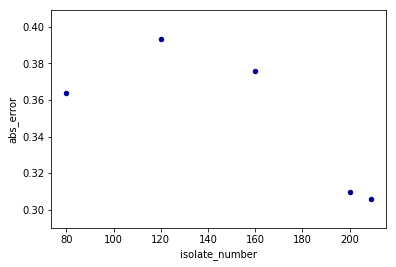

In [8]:
phy_un_df = phycorder_unweighted_df.plot.scatter(x='isolate_number',y='abs_error',c='DarkBlue')

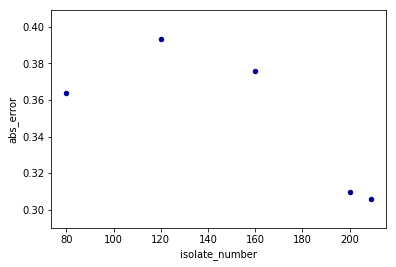

In [9]:
phy_mr_un_df = phycorder_mr_unweighted_df.plot.scatter(x='isolate_number',y='abs_error',c='DarkBlue')

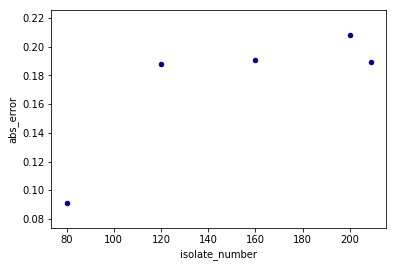

In [10]:
gon_phy_un_df = gon_phyling_unweighted_df.plot.scatter(x='isolate_number',y='abs_error',c='DarkBlue')

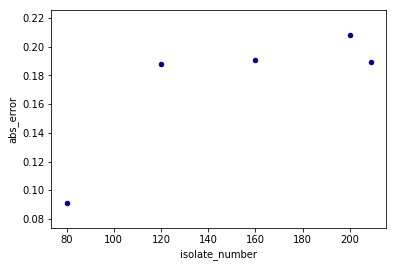

In [11]:
gon_phy_mr_un_df = gon_phyling_mr_unweighted_df.plot.scatter(x='isolate_number',y='abs_error',c='DarkBlue')

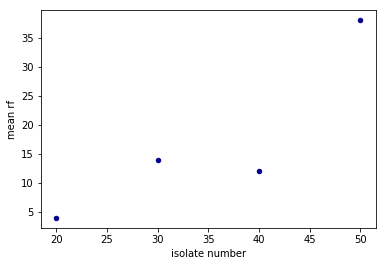

In [11]:
ax1 = unweighted_df.plot.scatter(x='isolate number',y='mean rf',c='DarkBlue')

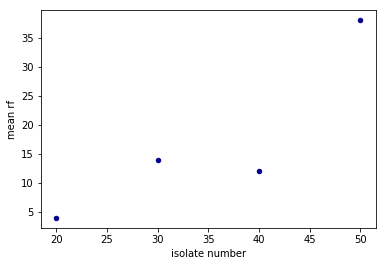

In [12]:
ax2 = mr_unweighted_df.plot.scatter(x='isolate number',y='mean rf',c='DarkBlue')

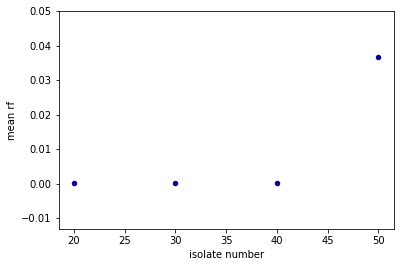

In [13]:
ax3 = weighted_df.plot.scatter(x='isolate number',y='mean rf',c='DarkBlue')

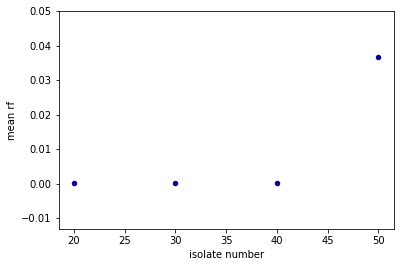

In [14]:
ax4 = mr_weighted_df.plot.scatter(x='isolate number',y='mean rf',c='DarkBlue')

In [ ]:
phy_un_df.figure.savefig(replicate_dir + "/"+ 'phycorder_unweighted_rf.png')
phy_mr_un_df.figure.savefig(replicate_dir + "/"+ 'phycorder_maj_rule_unweighted_rf.png')
gon_phy_un_df.figure.savefig(replicate_dir + "/"+ 'gon_phyling_unweighted_rf.png')
gon_phy_mr_un_df.figure.savefig(replicate_dir + "/"+ 'gon_phyling_maj_rule_unweighted_rf.png')

In [21]:
ax1.figure.savefig(replicate_dir + "/"+ 'unweighted_rf.png')
ax2.figure.savefig(replicate_dir + "/"+ 'maj_rule_unweighted_rf.png')
ax3.figure.savefig(replicate_dir + "/"+ 'weighted_rf.png')
ax4.figure.savefig(replicate_dir + "/"+ 'maj_rule_weighted_rf.png')

In [19]:
# ensure all trees loaded use common namespace
tns1 = dendropy.TaxonNamespace()

true_tree = dendropy.Tree.get(
    path = true_tree_file,
    schema='newick',
    preserve_underscores = True,
    taxon_namespace = tns1)

print(len(true_tree.leaf_nodes()))

# for tip in true_tree.leaf_iter():
#     print(tip)
# print(names_not_shared_list)

for label in names_not_shared_list:
    tns.remove_taxon_label(label)

for i in range(100):
    sim_tree = dendropy.simulate.treesim.birth_death_tree(1,0.8, num_extant_tips = len(tree2.leaf_nodes()), taxon_namespace = tns)
    print(treecompare.symmetric_difference(sim_tree, tree2))

209


In [22]:
tns

<TaxonNamespace 0x7f530cc0f198 'None': [<Taxon 0x7f530c97ce10 'taxon_29'>, <Taxon 0x7f530c9824e0 'taxon_28'>, <Taxon 0x7f530c984ef0 'taxon_24'>, <Taxon 0x7f530c888c88 'taxon_8'>, <Taxon 0x7f530c86c2e8 'taxon_34'>, <Taxon 0x7f530cb94710 'taxon_42'>, <Taxon 0x7f530cc1bd68 'taxon_37'>, <Taxon 0x7f530ce1abe0 'taxon_39'>, <Taxon 0x7f530ce0fe10 'taxon_43'>, <Taxon 0x7f530ce0f358 'taxon_48'>, <Taxon 0x7f530ce0fa20 'taxon_33'>, <Taxon 0x7f530ce10e10 'taxon_5'>, <Taxon 0x7f530ce10160 'taxon_45'>, <Taxon 0x7f530cde5160 'taxon_3'>, <Taxon 0x7f530ce03a90 'taxon_17'>, <Taxon 0x7f530ce03080 'taxon_41'>, <Taxon 0x7f530c535390 'taxon_18'>, <Taxon 0x7f530ce11908 'taxon_2'>, <Taxon 0x7f530c544780 'taxon_15'>, <Taxon 0x7f530c53fa20 'taxon_12'>, <Taxon 0x7f530c53feb8 'taxon_4'>, <Taxon 0x7f530c53f438 'taxon_44'>, <Taxon 0x7f530c53b898 'taxon_16'>, <Taxon 0x7f530c971cc0 'taxon_14'>, <Taxon 0x7f530c971320 'taxon_10'>, <Taxon 0x7f530cb8e198 'taxon_49'>, <Taxon 0x7f530cb8e400 'taxon_9'>, <Taxon 0x7f530cb8e518